In [1]:
# Citibike 2019 project, analyzing 2018 date of service trip data
# Github link: https://github.com/ygchan/Citibike/blob/master/Main.ipynb
# Author: George Chan, Sean Guo

In [2]:
# Import library and modules
import pandas as pd
import glob
import numpy as np
import os
import pprint
import pickle
import logging

# Display imagine in jupyter notebook
from IPython.display import Image
from IPython.core.display import HTML 

# Setup the graph's style
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from datetime import timedelta

logging.basicConfig(level=logging.DEBUG,
                    format='%(levelname)s - %(message)s')

logging.disable()

In [3]:
# Define where are the citibke 2018 zipfiles
data_folder = r'./Data/'
logging.debug('The data are stored in: ' + data_folder)

In [4]:
# Check what are the files in that folder
for folderName, subfolders, filenames in os.walk(data_folder):
    print('Here are the list of csv zip files you have downloaded.\n')
    print(os.path.abspath(folderName))
    
    number_of_csv_file = 0 # Total count of files read
    all_files = []         # List of file path string
    
    for filename in filenames:
        # If and only if they are csv files
        if filename.endswith('.csv'):
            number_of_csv_file += 1
            
            # Print to terminal to show user what files is found
            print('   ' + str(number_of_csv_file).zfill(2) + ': ' + filename)
            all_files.append(data_folder + filename)
            
    # Error if you forgot to download all 12 months.
    # For our project we want exactly 12 file
    assert number_of_csv_file == 12, 'Sorry, I think you are missing some files?'

Here are the list of csv zip files you have downloaded.

/Users/Study/Citibike_Git/Citibike/Data
   01: 201809-citibike-tripdata.csv
   02: 201801-citibike-tripdata.csv
   03: 201803-citibike-tripdata.csv
   04: 201805-citibike-tripdata.csv
   05: 201807-citibike-tripdata.csv
   06: 201811-citibike-tripdata.csv
   07: 201808-citibike-tripdata.csv
   08: 201802-citibike-tripdata.csv
   09: 201812-citibike-tripdata.csv
   10: 201804-citibike-tripdata.csv
   11: 201810-citibike-tripdata.csv
   12: 201806-citibike-tripdata.csv


In [5]:
def Update_Station(distinct_station_df, new_data_df):
    '''Reconcile and append any new stations to it'''
    
    start_columns = ['start_station_id', 
                     'start_station_name', 
                     'start_station_latitude', 
                     'start_station_longitude']

    end_columns = ['end_station_id', 
                   'end_station_name', 
                   'end_station_latitude', 
                   'end_station_longitude'] 
    
    # https://stackoverflow.com/a/14900065
    temp_station_start = new_data_df[start_columns].drop_duplicates(subset='start_station_id', keep='last')
    temp_station_start.columns = temp_station_start.columns.str.replace('start_', '')

    temp_station_end = new_data_df[end_columns].drop_duplicates(subset='end_station_id', keep='last')
    temp_station_end.columns = temp_station_end.columns.str.replace('end_', '')
    
    if distinct_station_df.shape[0] == 0:
        df_list = [temp_station_start, 
                   temp_station_end]
    else:
        df_list = [distinct_station_df,
                   temp_station_start, 
                   temp_station_end]
    
    distinct_station_df = pd.concat(df_list, sort=False)
    distinct_station_df = distinct_station_df.dropna()
    distinct_station_df.station_id = distinct_station_df.station_id.astype(int)
    
    # print(distinct_station_df.sample(5))
    distinct_station_df = distinct_station_df.drop_duplicates(subset='station_id', keep='last')
    distinct_station_df = distinct_station_df.sort_values(by='station_id').set_index('station_id')
    
    return distinct_station_df

# station_df = Update_Station(station_df, citibike)
# station_df

In [6]:
# tempCitibike list that store the file data frame
tempCitibike = []

# Citibike station
station = pd.DataFrame()

# Track how many records total
totalRecordCount = 0

df_storage = 'citibike_2018.pkl'
st_storage = 'citibike_station.pkl'

# If the file was properly loaded last time, re-use that dataframe
if (os.path.exists(df_storage)):
    citibike = pd.read_pickle(df_storage)
    station = pd.read_pickle(st_storage)

# Otherwise Load it from scratch
else:
    # Loop and append the dataframes into tempCitibke List
    for filename in sorted(all_files):
        # Filename is the path/file.ext
        print(os.path.basename(filename), end=" ")

        # df contains the entire dataset (CSV)
        df = pd.read_csv(filename) 

        # How to filter by values
        # https://stackoverflow.com/q/17071871

        # Experiment to see if only using annual membership will show a different
        # df = df.loc[df['usertype'] == 'Subscriber']
        
        # columns.str.replace(' ', '_')
        df.columns = df.columns.str.replace(' ', '_')

        # Because of limited computer resource (4GB of RAM...)
        # Radnomly select 5% of the data to load/test
        # with repeatable random state setting
        # df = df.sample(frac=0.05, replace=True, random_state=1)

        # Refresh the station id cross walk DataFrame
        station = Update_Station(station, df)
        
        # Safely drop the redundant elements to conserve memory
        df = df.drop(columns=['start_station_name', 
                      'start_station_latitude', 
                      'start_station_longitude',
                      'end_station_name', 
                      'end_station_latitude', 
                      'end_station_longitude',
                      'bikeid'])
        
        # Output the (rowCount, columnCount) to terminal
        print("size: " + str(df.shape))

        totalRecordCount += df.shape[0]
        tempCitibike.append(df)
        
        # Release the memory
        df = None

    # Combine the tempCitibike dfs together
    citibike = pd.concat(tempCitibike, sort=False)
    print("\nThere are {0:,}  number of records.".format(totalRecordCount))
    print("Before dropping NaN: {:,}".format(citibike.shape[0]))

    # Drop rows with any (missing) variables
    # Improve performance by not using inplace option
    # Reference: https://stackoverflow.com/q/22532302
    citibike = citibike.dropna()

    print("After dropping NaN: {:,}".format(citibike.shape[0]))
    
    # Store the citibike dataframe into a pickle object for future reference
    # This can save time from re-running the entire 17M records.
    citibike.to_pickle('citibike_2018.pkl')
    station.to_pickle('citibike_station.pkl')
    
# Release the memory
tempCitibike = None

201801-citibike-tripdata.csv size: (718994, 8)
201802-citibike-tripdata.csv size: (843114, 8)
201803-citibike-tripdata.csv size: (976672, 8)
201804-citibike-tripdata.csv size: (1307543, 8)
201805-citibike-tripdata.csv size: (1824710, 8)
201806-citibike-tripdata.csv size: (1953103, 8)
201807-citibike-tripdata.csv size: (1913625, 8)
201808-citibike-tripdata.csv size: (1977177, 8)
201809-citibike-tripdata.csv size: (1877884, 8)
201810-citibike-tripdata.csv size: (1878657, 8)
201811-citibike-tripdata.csv size: (1260355, 8)
201812-citibike-tripdata.csv size: (1016505, 8)

There are 17,548,339  number of records.
Before dropping NaN: 17,548,339
After dropping NaN: 17,545,842


In [7]:
pp = pprint.PrettyPrinter(indent=4)
print('The citibike DataFrame column names:')
pp.pprint(list(citibike.columns))

# Convert station ids from float to int
# https://stackoverflow.com/a/21291622
citibike.start_station_id = citibike.start_station_id.astype(int)
citibike.end_station_id = citibike.end_station_id.astype(int)

The citibike DataFrame column names:
[   'tripduration',
    'starttime',
    'stoptime',
    'start_station_id',
    'end_station_id',
    'usertype',
    'birth_year',
    'gender']


In [8]:
# Sample my dataset
citibike.sample(5)

,tripduration,starttime,stoptime,start_station_id,end_station_id,usertype,birth_year,gender
881438,515,2018-11-20 09:07:35.2380,2018-11-20 09:16:10.3820,532,3087,Subscriber,1975,1
751281,952,2018-02-09 16:06:59.4010,2018-02-09 16:22:52.1760,3427,304,Customer,1999,2
74275,1070,2018-01-23 21:10:29.7530,2018-01-23 21:28:19.9510,279,3632,Subscriber,1994,2
1007567,895,2018-11-25 10:03:34.9270,2018-11-25 10:18:30.7690,3709,514,Subscriber,1964,1
1504299,1421,2018-10-24 19:38:46.2250,2018-10-24 20:02:28.1880,79,519,Subscriber,1964,1


In [9]:
# Sample my dataset
station.sample(5)

,station_name,station_latitude,station_longitude
station_id,,,
3106,Driggs Ave & N Henry St,40.723250,-73.943080
326,E 11 St & 1 Ave,40.729538,-73.984267
368,Carmine St & 6 Ave,40.730386,-74.002150
3340,Wolcott St & Dwight St,40.675327,-74.010070
3314,W 95 St & Broadway,40.793770,-73.971888


In [10]:
# Explore the dataset 
citibike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17545842 entries, 0 to 1016504
Data columns (total 8 columns):
tripduration        int64
starttime           object
stoptime            object
start_station_id    int64
end_station_id      int64
usertype            object
birth_year          int64
gender              int64
dtypes: int64(5), object(3)
memory usage: 1.2+ GB


# Question 01: What is daily and monthly total ridership in 2018?

In [11]:
# What is the type of the starttime?
print('Type: ' + str(type(citibike['starttime'].values[0])))
print(citibike['starttime'].values[0])

Type: <class 'str'>
2018-01-01 13:50:57.4340


In [12]:
# Need to convert start_time and stop_time to datetime
formatString = '%Y-%m-%d %H:%M:%S.%f'

# Convert datetime column into 
citibike['starttime'] = pd.to_datetime(citibike['starttime'], format=formatString)
citibike['stoptime'] = pd.to_datetime(citibike['stoptime'], format=formatString)

In [13]:
# Confirm such convertion work, should be datetime64!
print('Type: ' + str(type(citibike['starttime'].values[0])))
print(citibike['starttime'].values[0])

Type: <class 'numpy.datetime64'>
2018-01-01T13:50:57.434000000


In [14]:
# Create another pandas dataframe that only has 1 columns
citibike_monthly_df = citibike.filter(['starttime']) # Monthly dataframe
citibike_daily_df = citibike.filter(['starttime'])   # Daily dataframe

# Each of the starttime is now converted into YYYY-MM
citibike_monthly_df.starttime = pd.to_datetime(citibike_monthly_df.starttime).dt.to_period('m')
citibike_daily_df.starttime = pd.to_datetime(citibike_daily_df.starttime).dt.to_period('d')

# Confirm if they are correct
citibike_daily_df.head()
citibike_monthly_df.head()

,starttime
0,2018-01
1,2018-01
2,2018-01
3,2018-01
4,2018-01


In [15]:
# Get frequency count of ridership data by month and day
monthly_answer = citibike_monthly_df.groupby(['starttime']).size()
daily_answer = citibike_daily_df.groupby(['starttime']).size()

In [16]:
# Checking to see what is monthly_answer type.
type(monthly_answer)

pandas.core.series.Series

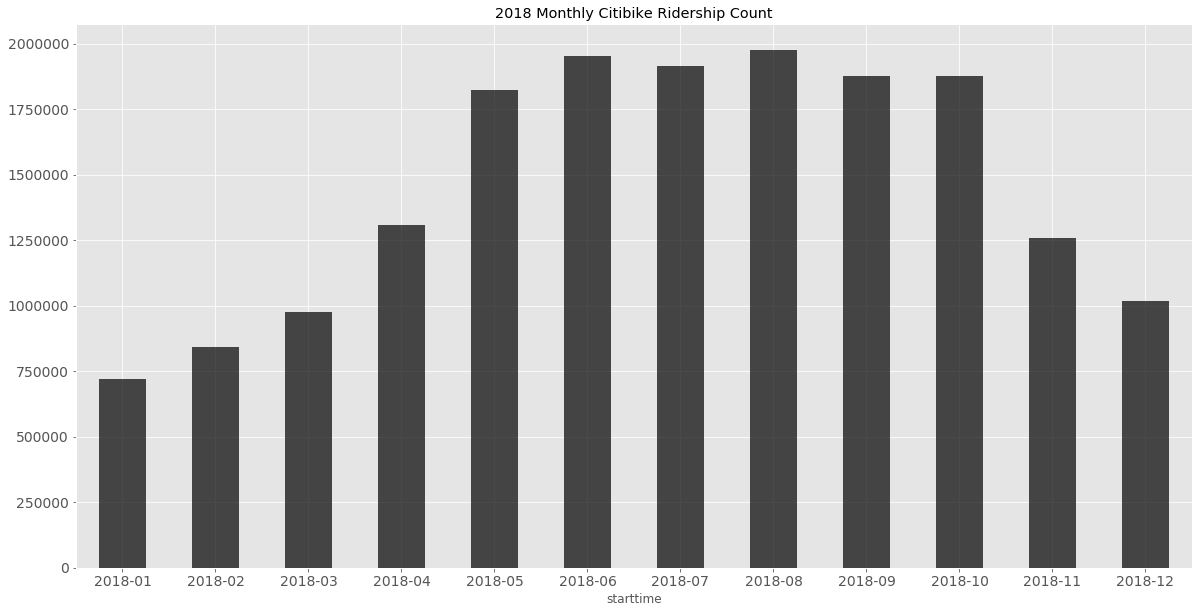

In [17]:
# Draw a basic plot for the monthly ridership data
monthly_answer.plot(
    figsize=(20,10), 
    kind='bar',
    title='2018 Monthly Citibike Ridership Count',
    fontsize=14,
    color='k',
    alpha=0.7,
    rot=0)

# Finally learned how to do it, you have to assign it to an object first.
# Reference: https://stackoverflow.com/a/21487560

# Then use set_xlable ...
# ax.set_xlabel('')

# Very complicated, 
# Reference: https://stackoverflow.com/a/25973637
# ax.get_yaxis().set_major_formatter(
#    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

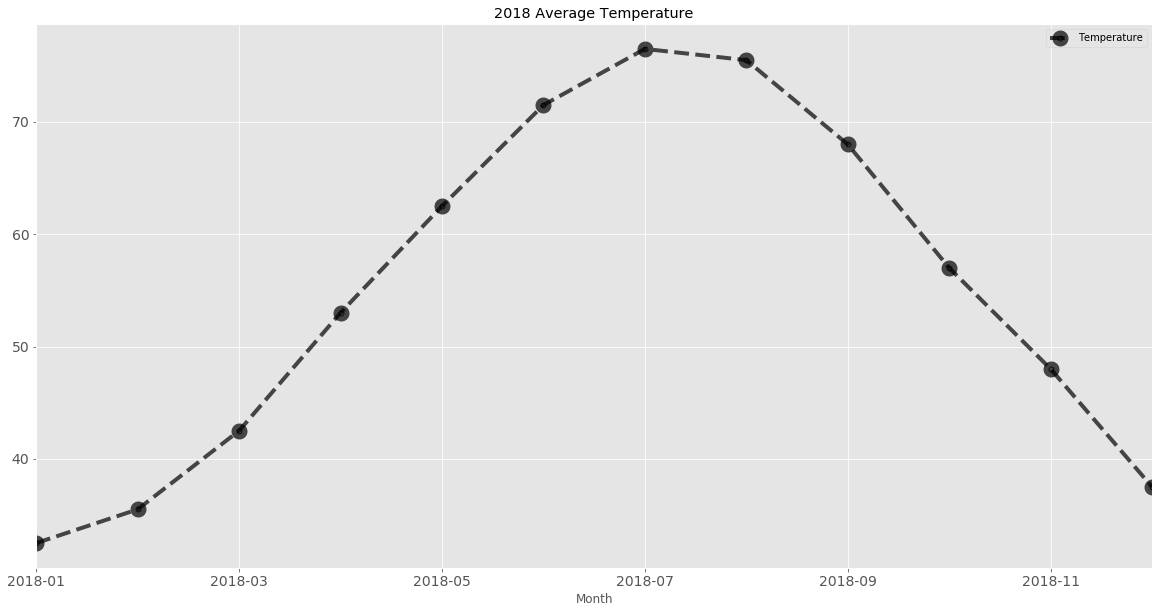

In [18]:
# Create a monthly temperature dictionary, data otained from google.
# probably need to find a way to get daily temperature in order to do more 
# in depth analysis and build a regression model.
temperature_dict = {
    'Month':['2018-01', 
             '2018-02',
             '2018-03',
             '2018-04',
             '2018-05',
             '2018-06',
             '2018-07',
             '2018-08',
             '2018-09',
             '2018-10',
             '2018-11',
             '2018-12'],
    'Temperature':[32.5, 35.5, 42.5, 53, 62.5, 71.5, 76.5, 75.5, 68, 57, 48, 37.5]
}

# Create a dataframe using the dictionary data
temperature_df = pd.DataFrame.from_dict(temperature_dict)

# Rename the columns properly
temperature_df = temperature_df.rename(index=str, columns={"Month": "Month", "Temperature": "Temperature"})

# Learned how to add x & y axis label
temperature_df.plot(
    x='Month',
    y='Temperature',
    figsize=(20,10), 
    kind='line',
    title='2018 Average Temperature',
    fontsize=14,
    linewidth=4.0, 
    markeredgewidth=10.0,
    linestyle='--', 
    marker='o',
    color='k',
    alpha=0.7,
    rot=0
)

In [19]:
# From this we can tell there are a strong relationship between the temperature 
# to the number of riders per day in the citibike. During winter month when it is
# really cold, you don't see nearly as much. But when it is warmer (in the summer)
# then you start to see a huge increase in the number of rides.

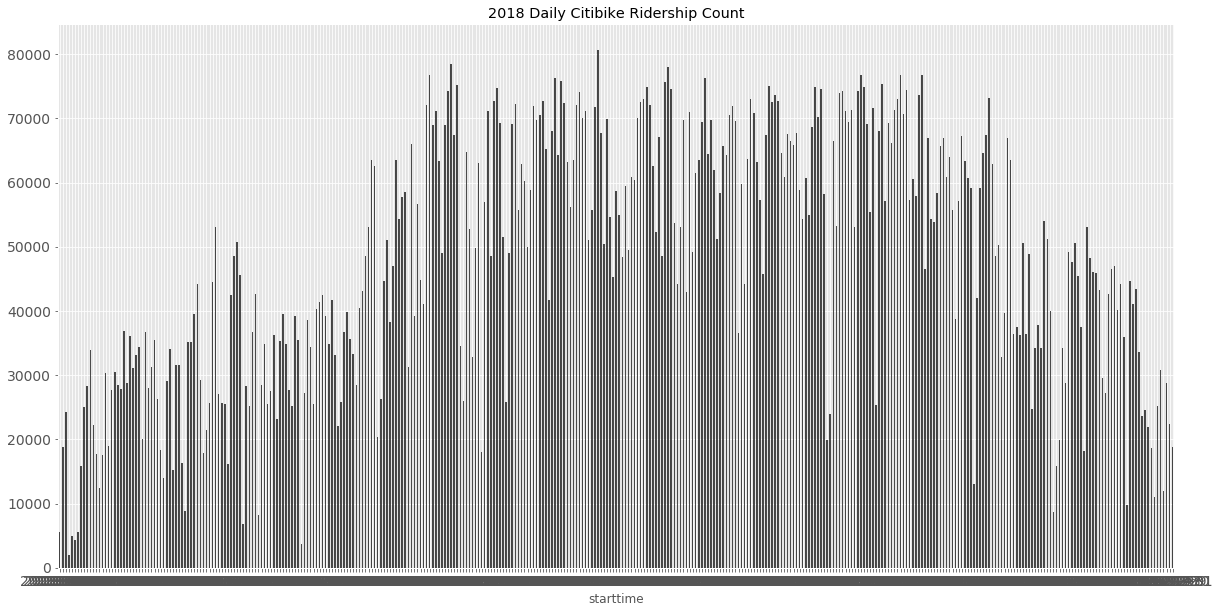

In [20]:
daily_answer.plot(
    figsize=(20,10),
    kind='bar',
    title='2018 Daily Citibike Ridership Count',
    fontsize=14,
    legend=False,
    color='k',
    alpha=0.7,
    rot=0
)

In [21]:
# Through manual checks on weather history, the dip in the individual months are 
# contributed by rain fall, when it is rainning that day, there are siginficantly
# less people riding a citibike. Because their clothings (pants) will get wet.
# And it is also unsafe to ride in the rain too, better to use mass transit.

In [22]:
# Most busy start station
# https://stackoverflow.com/q/29836477
# http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
key = 'start_station_id'
start_station_df = citibike.groupby(key)[key].count().reset_index(name='count')
start_station_df.sort_values(by='count', ascending=False, inplace=True)

# Getting the station name
start_station_df = start_station_df.merge(station[['station_name']], 
                                          how='inner', 
                                          left_on='start_station_id',
                                          right_on='station_id')

# Question 02: What is the most / least popular station?

In [23]:
# Most busy start station
# https://stackoverflow.com/q/29836477
# http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
key = 'start_station_id'
key = 'start_station_id'

start_station_df = citibike.groupby(key)[key].count().reset_index(name='count')
start_station_df.sort_values(by='count', ascending=False, inplace=True)

# Getting the station name
start_station_df = start_station_df.merge(station[['station_name']], 
                                          how='inner', 
                                          left_on='start_station_id',
                                          right_on='station_id',
                                          )

# The most popular start stations award goes to...
print('The most popular start station: ' + str(start_station_df.iloc[0][2]), end='')
print(' ({:,} times)'.format(start_station_df.iloc[0][1]))

# Most busy end station
key = 'end_station_id'
end_station_df = citibike.groupby(key)[key].count().reset_index(name='count')
end_station_df.sort_values(by='count', ascending=False, inplace=True)

# Getting the station name
end_station_df = end_station_df.merge(station[['station_name']],
                                      how='inner',
                                      left_on='end_station_id',
                                      right_on='station_id')

print('The most popular end station:   ' + str(end_station_df.iloc[0][2]), end='')
print(' ({:,} times)'.format(end_station_df.iloc[0][1]))

# Some information about this station
print('\nFrom Wiki: Pershing Square is a public square in Manhattan, New York City. ')
print('Located where Park Avenue and 42nd Street intersect in front of Grand Central Terminal.')
print('The main roadway of Park Avenue crosses over 42nd Street on the Park Avenue Viaduct. ')
print('It is also known as the Pershing Square Viaduct.')

Image(url="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a8/Park_Avenue_Viaduct_Pershing_Square_from_west.jpg/1920px-Park_Avenue_Viaduct_Pershing_Square_from_west.jpg",
      width=400, 
      height=400)


# Top 10 one way direction...
# Chart Annual rider vs. Weekly rider vs. Single rider

The most popular start station: Pershing Square North (150,257 times)
The most popular end station:   Pershing Square North (149,932 times)

From Wiki: Pershing Square is a public square in Manhattan, New York City. 
Located where Park Avenue and 42nd Street intersect in front of Grand Central Terminal.
The main roadway of Park Avenue crosses over 42nd Street on the Park Avenue Viaduct. 
It is also known as the Pershing Square Viaduct.


In [24]:
# Top 10 popular start stations
print('Top 10 popular start station')
start_station_df.head(10)

Top 10 popular start station


,start_station_id,count,station_name
0,519,150257,Pershing Square North
1,497,108883,E 17 St & Broadway
2,435,107165,W 21 St & 6 Ave
3,402,105605,Broadway & E 22 St
4,426,94466,West St & Chambers St
5,285,93370,Broadway & E 14 St
6,477,87956,W 41 St & 8 Ave
7,490,85293,8 Ave & W 33 St
8,499,84963,Broadway & W 60 St
9,293,83025,Lafayette St & E 8 St


In [25]:
# Release memory
start_station_df = None
end_station_df = None

In [72]:
# https://stackoverflow.com/q/54009788
# This analysis exclude the trip where they start and end at the same station
# Because it is actually central park, I am guessing for tourist?

# Do not want the trip start and end at the same place
citibike_trip = citibike[citibike['start_station_id'] != citibike['end_station_id']]

# Create a subset dataframe with only start & end station name
citibike_trip = citibike_trip.filter(['start_station_id', 'end_station_id'])

# Create the trip string
citibike_trip['trip'] = citibike_trip['start_station_id'].astype(str) + ',' + citibike_trip['end_station_id'].astype(str)

# Group by trip and add count column
trip_df = citibike_trip.groupby('trip')['trip'].count().reset_index(name='count')
trip_df.sort_values(by='count', ascending=False, inplace=True)

In [73]:
top_5000_trips = trip_df.iloc[0:5000, :]
one_off_trip = trip_df[trip_df['count'] == 1]

In [74]:
# Sample the top 100 trips
top_100_trips.head(5)

,trip,count,start_id
290346,"432,3263",7249,"[432, 3263]"
12088,"2006,3282",6215,"[2006, 3282]"
303605,"460,3093",5456,"[460, 3093]"
68964,"3093,460",5137,"[3093, 460]"
291936,"435,509",4996,"[435, 509]"


In [75]:
citibike_trip = None
trip_df = None

In [76]:
# Print out the result
start_id = int(top_100_trips.iloc[0, :][0].split(',')[0])
end_id = int(top_100_trips.iloc[0, :][0].split(',')[1])

print('ID:', start_id, ',', end_id)
start_name = station.loc[start_id]['station_name']
end_name = station.loc[end_id]['station_name']
trip_string = start_name + ' to ' + end_name

print('In 2018:', end='')
print('The most popular ride is : ' + trip_string, end='')
print(' ({} times)'.format(top_100_trips.iloc[0][1]))

# How to insert an image: https://stackoverflow.com/a/32370538
Image(url="https://i.ibb.co/J72SggW/map1.png",
      width=600, 
      height=600)

ID: 432 , 3263
In 2018:The most popular ride is : E 7 St & Avenue A to Cooper Square & Astor Pl (7249 times)


## There are many 1 off trips (not meaningful to say least popular)

In [77]:
count = one_off_trip.shape[0]

# These are station to station ride that only happened once
print('There are {0:,} count of one-off trips.'.format(count))

There are 64,757 count of one-off trips.


# What are the type of membership (Annual members or paid per ride?)

In [78]:
# This is george's another way of getting the count and making it 
# back to a DataFrame, after reading the book a bunch.
membership = citibike.groupby('usertype')['usertype'].count()

# In order to use pd.plot, but maybe you use can it as is?
membership = pd.DataFrame(membership)
membership.rename(columns={'usertype': 'count'})

# count = list(membership)
# label = list(membership.index)

,count
usertype,
Customer,1932472
Subscriber,15613370


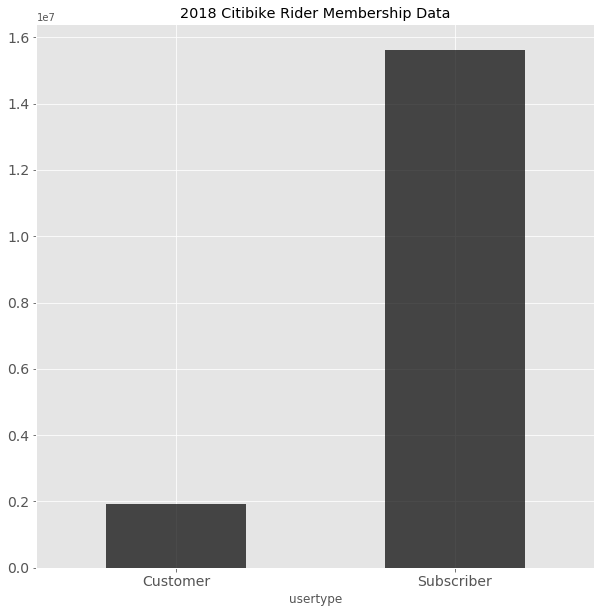

In [79]:
# Reference: https://markhneedham.com/blog/2018/09/18/matplotlib-remove-axis-legend/
membership.plot(
    figsize=(10,10),
    title='2018 Citibike Rider Membership Data', 
    fontsize=14,
    kind='bar',
    rot=0,
    legend=None,
    color='k',
    alpha=0.7,
    )

In [80]:
gender_df = citibike.groupby('gender')['gender'].count()
gender_df = gender_df.reset_index(name='count')
gender_df = gender_df.set_index(['gender'])

# Set the index so it will print properly
gender_df.rename(index={0: 'Unknown', 
                        1: 'Male',
                        2: 'Female'}, 
                        inplace=True)

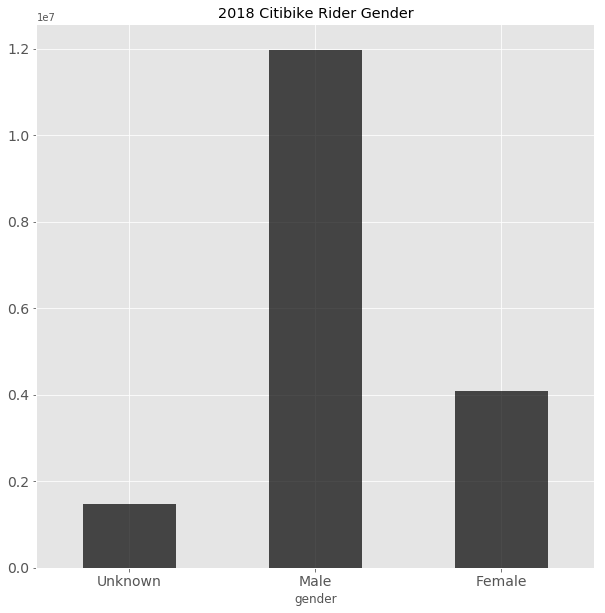

In [81]:
# Reference: https://markhneedham.com/blog/2018/09/18/matplotlib-remove-axis-legend/
gender_df.plot(
    figsize=(10,10),
    title='2018 Citibike Rider Gender',
    fontsize=14,
    kind='bar',
    rot=0,
    legend=None,
    color='k',
    alpha=0.7
)

In [82]:
# Age Group
# https://stackoverflow.com/a/34683105
age_df = citibike[['birth_year']].copy()

# Replace the column names
# age_df.columns = age_df.columns.str.strip().str.lower().str.replace(' ', '_')

# Failed attempt...
# age_df['age'] = age_df.apply(lambda row: row['birth_year'])

# Citibike appears to place 50 as dummy value, and 49 might also
# but a dummy value - to be confirmed.
def get_age(year_of_birth):
    result = 2019 - int(year_of_birth)
    if result >= 0 and result <=80 and result != 50:
        return result
    else:
        return -1

# Calculate a new column by using vectorize method
age_df['age'] = np.vectorize(get_age)(age_df['birth_year'])

age_df = age_df[age_df['age'] != -1]

age_plot_df = age_df.groupby('age')['age'].count()
age_plot_df = age_plot_df.reset_index(name = 'count')
age_plot_df = age_plot_df.set_index(['age'])

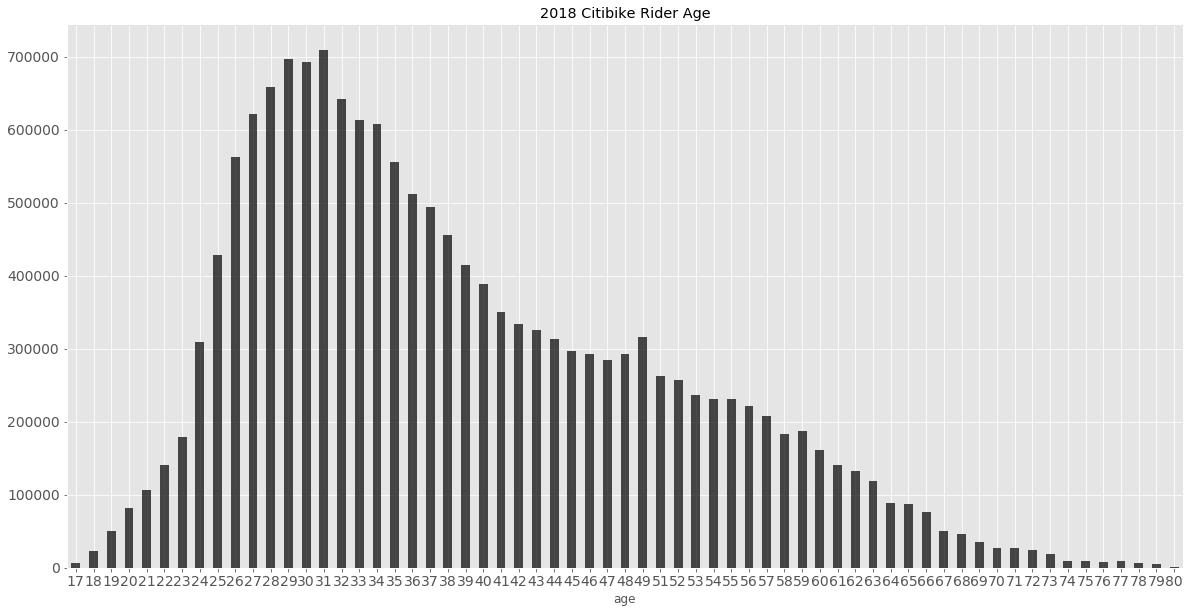

In [83]:
age_plot_df.plot(
    figsize=(20,10), 
    title='2018 Citibike Rider Age', 
    fontsize=14,
    kind='bar',
    rot=0,
    legend=None,
    color='k',
    alpha=0.7
)

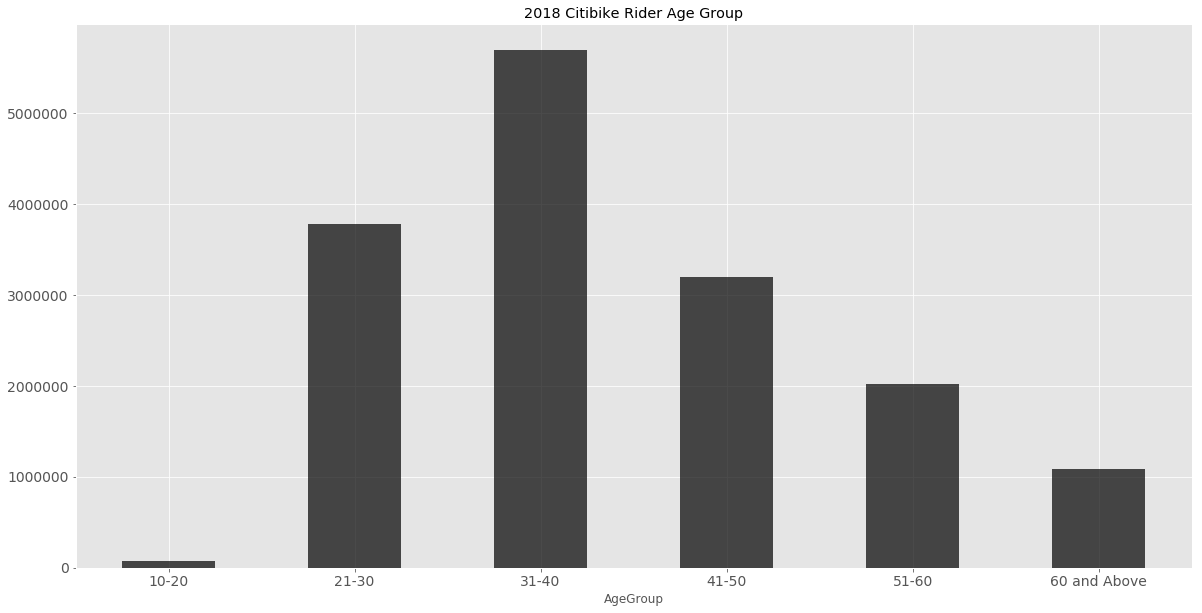

In [84]:
# bins = [0, 24, 59, 999]
# labels = ['Student <=24','Adult','Senior Adult']

bins=[0, 20, 30, 40, 50, 60, 100]
labels=['10-20', '21-30', '31-40', '41-50', '51-60', '60 and Above']

age_df['AgeGroup'] = pd.cut(age_df['age'], bins=bins, labels=labels, right=False)

agegroup_plot_df = age_df.groupby('AgeGroup')['AgeGroup'].count()
agegroup_plot_df = agegroup_plot_df.reset_index(name='count')
agegroup_plot_df = agegroup_plot_df.set_index(['AgeGroup'])

agegroup_plot_df.plot(
    figsize=(20,10), 
    title='2018 Citibike Rider Age Group', 
    fontsize=14,
    kind='bar',
    rot=0,
    legend=None,
    color='k',
    alpha=0.7
)

In [85]:
# https://stackoverflow.com/a/43211266
from math import sin, cos, sqrt, atan2, radians

def get_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in miles 
    R = 3958.8

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

def get_duration(datetime1, datetime2):
    # https://stackoverflow.com/a/14920923
    duration = datetime2 - datetime1
    return duration.total_seconds()
    
def get_speed(distance, duration):
    hour = 60.0 * 60.0 * 60.0 / (seconds)
    
    # return distance per hour
    return (distance/hour)

ans = get_distance(40.729538, -73.984267, 40.736197, -74.008592)
ans = get_distance(40.730260, -73.953940, 40.729060, -73.957790)

print("Result:", ans)

Result: 0.21796866823983926


In [116]:
import numpy as np

df = citibike.sample(frac=0.1, replace=True, random_state=1)

In [117]:
df = df.merge(station, how='inner',
         left_on='start_station_id',
         right_on='station_id')

In [118]:
df = df.rename(columns={'station_latitude': 'start_station_latitude',
                        'station_longitude': 'start_station_longitude',
                        'station_name': 'start_station_name'})

In [119]:
df = df.merge(station, how='inner',
         left_on='end_station_id',
         right_on='station_id')

In [120]:
df = df.rename(columns={'station_latitude': 'end_station_latitude',
                        'station_longitude': 'end_station_longitude',
                        'station_name': 'end_station_name'})

In [121]:
# Vectorize: https://stackoverflow.com/q/19914937
# start station latitude, start station longitude
df['distance'] = np.vectorize(get_distance)(df['start_station_latitude'],
                                     df['start_station_longitude'],
                                     df['end_station_latitude'],
                                     df['end_station_longitude'])



# df['duration'] = np.vectorize(get_duration)(df['starttime'], df['stoptime'])
# df['C'] = (df['B'] - df['A'])/ np.timedelta64(1, 's')
df['duration'] = (df['stoptime'] - df['starttime']) / np.timedelta64(1, 's')

df['speed'] = (df['distance'] / ((60.0 * 60.0) / df['duration']))

# citibike_trip = citibike[citibike['start station name'] != citibike['end station name']]
commute_trip = df[df['start_station_name'] != df['end_station_name']]

# Limit the ride that is slower than walking and within reason
commute_trip = commute_trip[(commute_trip['speed'] >= 3.5)
                            & (commute_trip['speed'] <= 25)]

# commute_trip = commute_trip[commute_trip['birth year'] >= 1989]

'''
Speeds above 16 mph are considered very vigorous while riding a bicycle. 
A light pace would be 10 to 11.9 mph while a moderate pace is categorized as 12 to 13.9 mph. 
If you are a beginner, start at a light or moderate pace and ride at speeds between 10 and 14 mph.
'''

speed_bins = [0, 9, 12, 15, 99]
speed_labels = ['Leisurely (< 9 MPH)', 'Fast MPH (9 - 11.9 MPH)', 'Moderate (12 - 14.9 MPH)', 'Vigorous (15 MPH+)']

commute_trip['SpeedGroup'] = pd.cut(commute_trip['speed'], bins=speed_bins, labels=speed_labels, right=False)

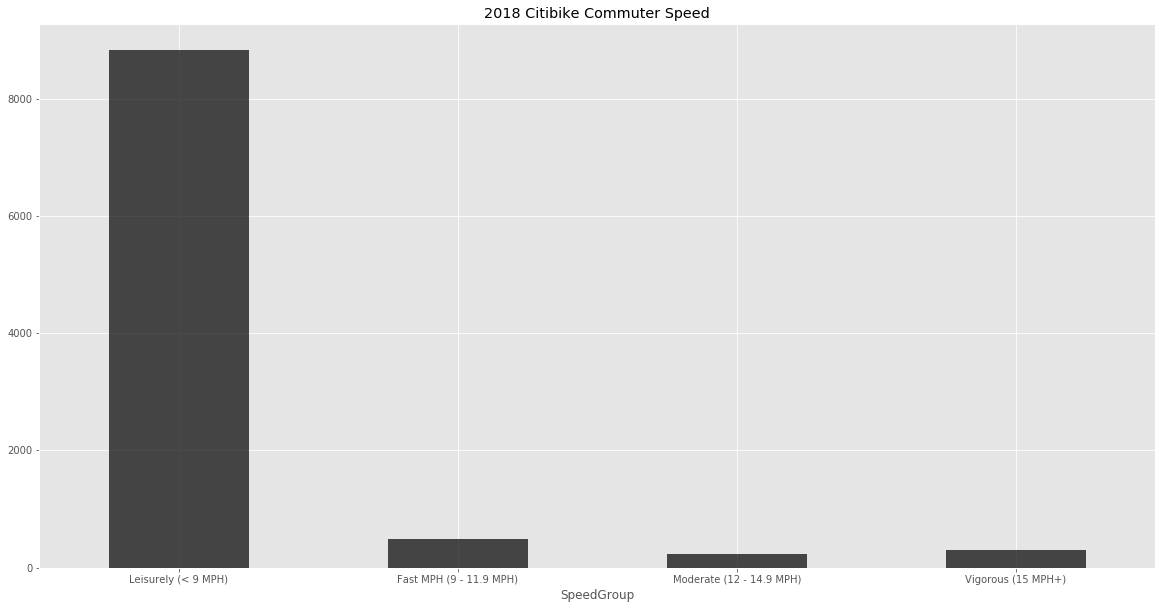

In [131]:
commute_trip_plot = commute_trip.groupby('SpeedGroup')['SpeedGroup'].count()
commute_trip_plot = commute_trip_plot.reset_index(name = 'count')
commute_trip_plot = commute_trip_plot.set_index(['SpeedGroup'])

commute_trip_plot.plot(
    figsize=(20,10), 
    title='2018 Citibike Commuter Speed', 
    kind='bar',
    rot=0,
    legend=None,
    color='k',
    alpha=0.7
)

In [126]:
# Distance Histogram
df['distance'].describe()

count    1.646802e+06
mean     1.113790e+00
std      8.922219e-01
min      0.000000e+00
25%      5.138915e-01
50%      8.534787e-01
75%      1.439003e+00
max      1.053291e+01
Name: distance, dtype: float64

In [127]:
dist_bins = np.linspace(start=0., stop=11., num=50)
dist_bins

array([ 0.        ,  0.2244898 ,  0.44897959,  0.67346939,  0.89795918,
        1.12244898,  1.34693878,  1.57142857,  1.79591837,  2.02040816,
        2.24489796,  2.46938776,  2.69387755,  2.91836735,  3.14285714,
        3.36734694,  3.59183673,  3.81632653,  4.04081633,  4.26530612,
        4.48979592,  4.71428571,  4.93877551,  5.16326531,  5.3877551 ,
        5.6122449 ,  5.83673469,  6.06122449,  6.28571429,  6.51020408,
        6.73469388,  6.95918367,  7.18367347,  7.40816327,  7.63265306,
        7.85714286,  8.08163265,  8.30612245,  8.53061224,  8.75510204,
        8.97959184,  9.20408163,  9.42857143,  9.65306122,  9.87755102,
       10.10204082, 10.32653061, 10.55102041, 10.7755102 , 11.        ])

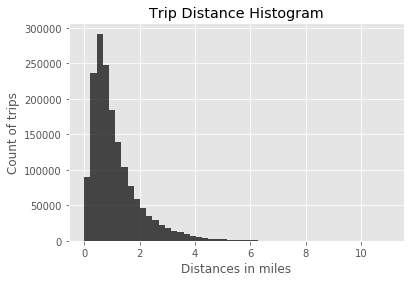

In [133]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

props = {
    'title': 'Trip Distance Histogram',
    'xlabel': 'Distances in miles',
    'ylabel': 'Count of trips'
}

ax.set(**props)
df.distance.hist(ax=ax,
                 bins=dist_bins,
                 color='k',
                 alpha=0.7)